In [28]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import normaltest 
from arch import arch_model
import numpy as np
import yfinance as yf

sns.set_style("whitegrid")  
plt.rcParams["figure.figsize"] = (10, 6)

In [29]:
ticker = "NFLX"
company = yf.Ticker(ticker)

In [30]:
yesterday = datetime.now() - timedelta(days=1)
start_date = yesterday - timedelta(days = 1095)
yesterday = yesterday.strftime("%Y-%m-%d")
start_date = start_date.strftime("%Y-%m-%d")

In [31]:
data = yf.download(ticker, start = start_date, end = yesterday)
data = data.reset_index()
data.columns = data.columns.get_level_values(0)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0) 
data['Date'] = pd.to_datetime(data['Date'])


*********************100%***********************]  1 of 1 completed

In [32]:
data = data.set_index('Date')
close_data = data['Close']
open_data = data['Open']

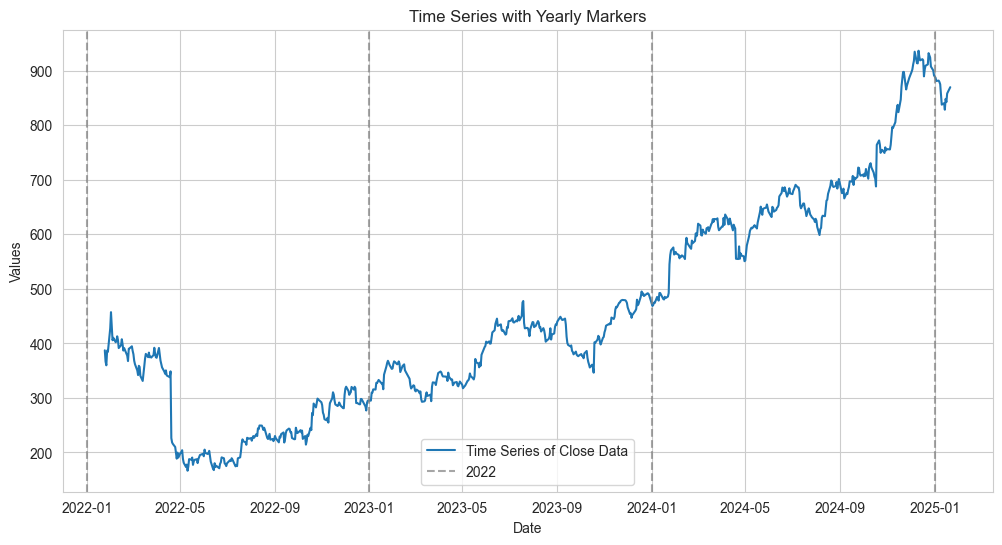

In [34]:
# Plot the time series for visual inspection with vertical year lines: 
plt.figure(figsize=(12, 6))
plt.plot(close_data, label='Time Series of Close Data')

# Add vertical dashed lines for each year
for year in range(close_data.index.year.min(), close_data.index.year.max() + 1):
    plt.axvline(pd.Timestamp(f'{year}-01-01'), color='gray', linestyle='--', alpha=0.7, label=f'{year}' if year == close_data.index.year.min() else None)

# # Add vertical dashed lines for each year
# for year in range(close_data.index.year.min(), close_data.index.year.max() + 1):
#     for quarter_start_month in [1, 4, 7, 10]:  # Start of each quarter
#         quarter_date = pd.Timestamp(f'{year}-{quarter_start_month:02d}-01')
#         if quarter_date in close_data.index:  # Only add lines within the data range
#             plt.axvline(quarter_date, color='gray', linestyle='--', alpha=0.7)
# Customizing the plot
plt.title('Time Series with Yearly Markers')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

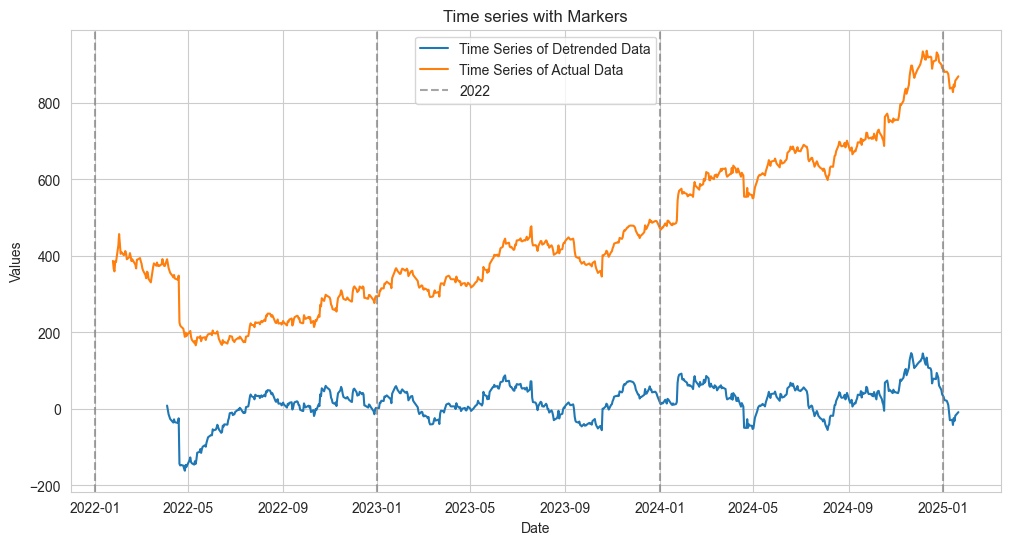

In [35]:
moving_avg = close_data.rolling(window=50).mean()  # 50-day moving average
detrended = (close_data - moving_avg).dropna()

#plotting detrended series to observe any patterns 
plt.figure(figsize=(12, 6))
plt.plot(detrended, label='Time Series of Detrended Data')
plt.plot(close_data, label='Time Series of Actual Data')

# Add vertical dashed lines for each year
for year in range(detrended.index.year.min(), detrended.index.year.max() + 1):
    plt.axvline(pd.Timestamp(f'{year}-01-01'), color='gray', linestyle='--', alpha=0.7, label=f'{year}' if year == detrended.index.year.min() else None)

# Customizing the plot
plt.title('Time series with Markers')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

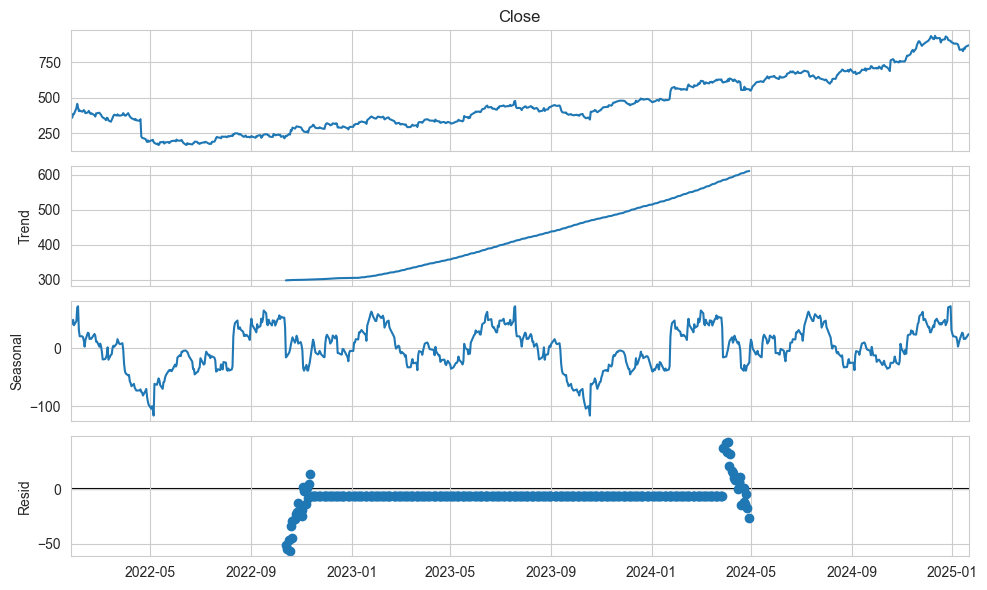

Price
Adj Close    0.998081
Close        0.998081
High         0.998104
Low          0.998055
Open         0.998079
Volume       1.000000
dtype: float64


In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(close_data, model='additive', period=365)  # Use 'multiplicative' if the data has proportional seasonal patterns

# Plot the decomposed components
result.plot()
plt.show()

# Compute seasonal strength
seasonal_var = result.seasonal.var()
residual_var = result.resid.var()
original_var = data.var()

seasonal_strength = 1 - (residual_var / original_var)
print(seasonal_strength)

#According to the graph below, the trend is obviously upwards and the season passes a year where a strong dip can be seen every year and a half with two smaller dips within the large dip gaps. 

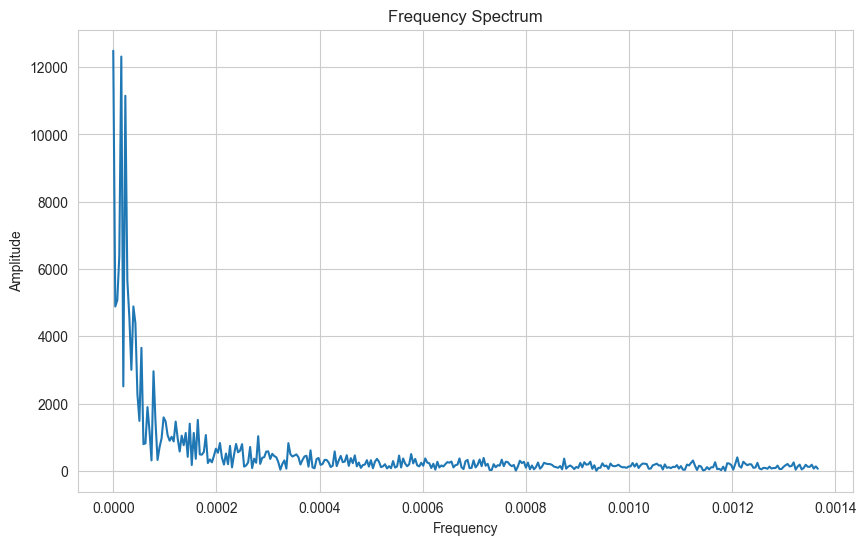

In [40]:
# Compute FFT
fft = np.fft.fft(detrended.values)
frequencies = np.fft.fftfreq(len(detrended), d=365)  # d=1 assumes daily frequency

# Plot the FFT spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies[:len(frequencies)//2], np.abs(fft)[:len(fft)//2])
plt.title('Frequency Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

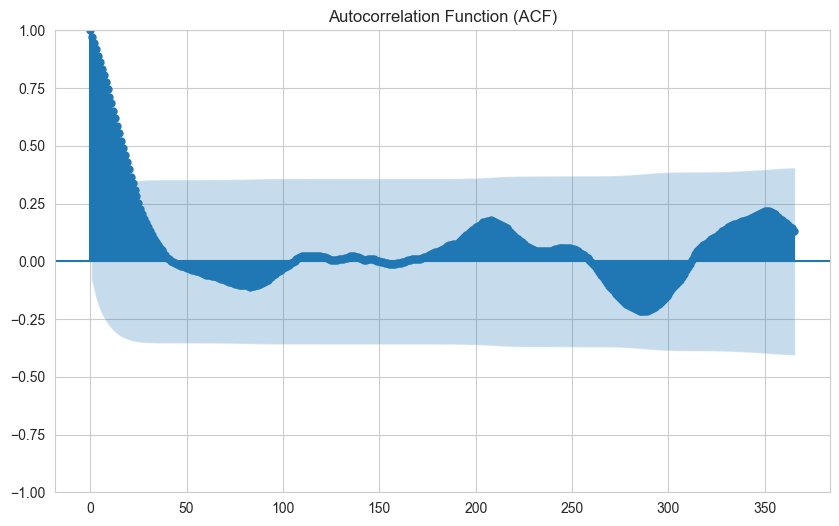

In [43]:
# Plot ACF
plot_acf(detrended, lags=365)
plt.title('Autocorrelation Function (ACF)')
plt.show()

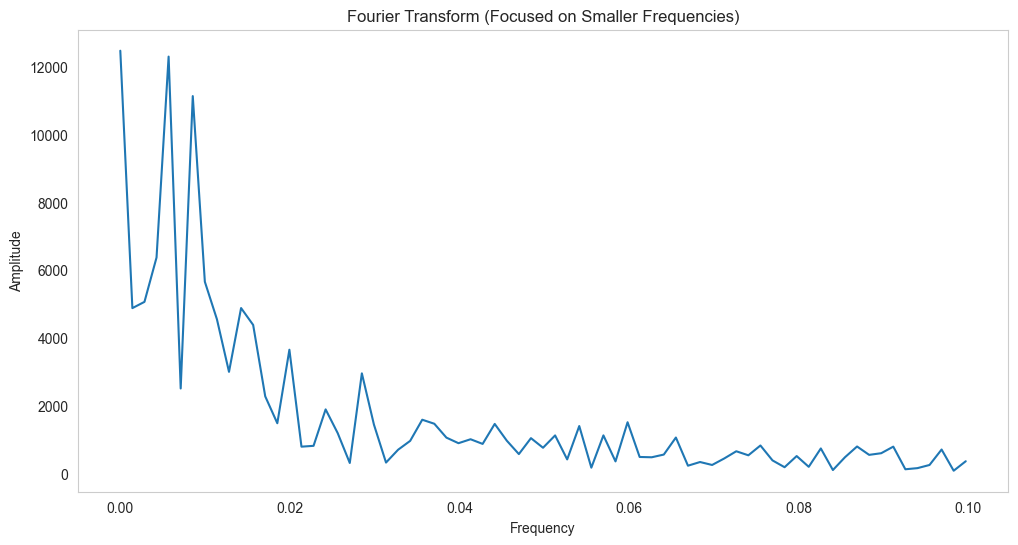

In [41]:
# Generate FFT
fft = np.fft.fft(detrended.values)
frequencies = np.fft.fftfreq(len(detrended), d=1)  # d=1 assumes daily data

# Keep only the positive frequencies
positive_freqs = frequencies[:len(frequencies)//2]
positive_amplitudes = np.abs(fft)[:len(fft)//2]

# Focus on smaller frequencies
freq_cutoff = 0.1  # Adjust this to zoom in on the desired range
filtered_indices = positive_freqs <= freq_cutoff

# Plot the focused Fourier spectrum
plt.figure(figsize=(12, 6))
plt.plot(positive_freqs[filtered_indices], positive_amplitudes[filtered_indices])
plt.title('Fourier Transform (Focused on Smaller Frequencies)')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

# Within the fft graph, the frequenceies corresponding the spikes can be used to calculate periods where 1/f is the period. So smaller freqencies show larger periods while larger frequencies show smaller periods. 

In [ ]:
#Additionally, trend analysis can be performed using visual inspection, moving average graph, moving_avg = data.rolling(window=50).mean(), 
# seasonal decomposition, fitting regression line # Fit a linear regression model
# model = LinearRegression()
# model.fit(time, data.values)

# # Predict trend
# trend_line = model.predict(time)

# from sklearn.linear_model import LinearRegression

#Hypothesis testing using ad_fuller method to check for stationarity or non stationarity. 
